# Inspect Jingcheng's biophysical modeling results

In [2]:
import os
import json
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm
import warnings
from scipy.signal import find_peaks, butter, filtfilt
from scipy.optimize import curve_fit
from scipy.ndimage import binary_opening, label
import seaborn as sns
import ast
from matplotlib.animation import FuncAnimation

# ignore runtime warning
warnings.filterwarnings("ignore", category=RuntimeWarning)

root_folder_path = '/G/results/simulation/'

*The root_folder_path of the datasets is D:. Please change it according to the path where you save these datasets in local.*

### Necessary functions for analysis

In [3]:
def load_data(exp):
    
    try:
        # v_path = [root_folder_path, exp, 'dend_v_array.npy']
        # i_path = [root_folder_path, exp, 'dend_i_array.npy']
        # nmda_path = [root_folder_path, exp, 'dend_nmda_i_array.npy']
        # ampa_path = [root_folder_path, exp, 'dend_ampa_i_array.npy']
        
        # nmda_g_path = [root_folder_path, exp, 'dend_nmda_g_array.npy']
        # ampa_g_path = [root_folder_path, exp, 'dend_ampa_g_array.npy']
        
        soma_path = [root_folder_path, exp, 'soma_v_array.npy']
        apic_v_path = [root_folder_path, exp, 'apic_v_array.npy']
        # apic_ica_path = [root_folder_path, exp, 'apic_ica_array.npy']

        # soma_i_path = [root_folder_path, exp, 'soma_i_array.npy']
            
        # trunk_v_path = [root_folder_path, exp, 'trunk_v_array.npy']
        # basal_v_path = [root_folder_path, exp, 'basal_v_array.npy']
        # tuft_v_path = [root_folder_path, exp, 'tuft_v_array.npy']

        # basal_bg_i_nmda_path = [root_folder_path, exp, 'basal_bg_i_nmda_array.npy']
        # basal_bg_i_ampa_path = [root_folder_path, exp, 'basal_bg_i_ampa_array.npy']
        # tuft_bg_i_nmda_path = [root_folder_path, exp, 'tuft_bg_i_nmda_array.npy']
        # tuft_bg_i_ampa_path = [root_folder_path, exp, 'tuft_bg_i_ampa_array.npy']
        
        # seg_v_path = [root_folder_path, exp, 'seg_v_array.npy']

        # v = np.load(os.path.join(*v_path))
        # i = np.load(os.path.join(*i_path))
        # nmda = np.load(os.path.join(*nmda_path))
        # ampa = np.load(os.path.join(*ampa_path))
        
        # nmda_g = np.load(os.path.join(*nmda_g_path))
        # ampa_g = np.load(os.path.join(*ampa_g_path))
        
        soma = np.load(os.path.join(*soma_path))
        apic_v = np.load(os.path.join(*apic_v_path))
        # apic_ica = np.load(os.path.join(*apic_ica_path))

        # soma_i = np.load(os.path.join(*soma_i_path))

        # trunk_v = np.load(os.path.join(*trunk_v_path))
        # basal_v = np.load(os.path.join(*basal_v_path))
        # tuft_v = np.load(os.path.join(*tuft_v_path))

        # basal_bg_i_nmda = np.load(os.path.join(*basal_bg_i_nmda_path))
        # basal_bg_i_ampa = np.load(os.path.join(*basal_bg_i_ampa_path))
        # tuft_bg_i_nmda = np.load(os.path.join(*tuft_bg_i_nmda_path))
        # tuft_bg_i_ampa = np.load(os.path.join(*tuft_bg_i_ampa_path)) 

        # seg_v = np.load(os.path.join(*seg_v_path))

    except FileNotFoundError:
        pass

    dt = 1/40000

    # read info from json and add to plot
    with open(os.path.join(root_folder_path, exp, 'simulation_params.json')) as f:
        simu_info = json.load(f)
    
    with open(os.path.join(root_folder_path, exp, 'section_synapse_df.csv')) as f:
        sec_syn_df = pd.read_csv(f)

    try:
        return v, i, nmda, ampa, nmda_g, ampa_g, soma, apic_v, apic_ica, soma_i, \
               trunk_v, basal_v, tuft_v, basal_bg_i_nmda, basal_bg_i_ampa, \
               tuft_bg_i_nmda, tuft_bg_i_ampa, dt, simu_info, sec_syn_df
    
    except NameError:
        return soma, apic_v, dt, simu_info, sec_syn_df

## Visualization

In [5]:
def visualization(exp, syn_num=0, trial_idx=0, t_start=0, t_end=1000):
    try:
        v, i, nmda, ampa, nmda_g, ampa_g, soma, apic_v, apic_ica, soma_i, \
        trunk_v, basal_v, tuft_v, basal_bg_i_nmda, basal_bg_i_ampa, \
        tuft_bg_i_nmda, tuft_bg_i_ampa, dt, simu_info, sec_syn_df = load_data(exp)
    
    except ValueError:
        soma, apic_v, dt, simu_info, sec_syn_df = load_data(exp)
    
    if soma.ndim == 4:
        # v = np.mean(v, axis=2) # shape: [num_clusters, num_times, num_affs, num_trials]
        soma = np.mean(soma, axis=1) # shape: [num_times, num_affs, num_trials]
        apic_v = np.mean(apic_v, axis=1) # shape: [num_times, num_affs, num_trials]
        # trunk_v = np.mean(trunk_v, axis=1) # shape: [num_times, num_affs, num_trials]
        # basal_v = np.mean(basal_v, axis=1) # shape: [num_times, num_affs, num_trials]
        # tuft_v = np.mean(tuft_v, axis=1) # shape: [num_times, num_affs, num_trials]
        
    t = simu_info['time point of stimulation']
    t_start, t_end = t_start*40, t_end*40
    t_vals = np.arange(t_start, t_end)*dt 
    
    color_list = ['C0', 'C1', 'C2']#, 'C3']#, 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
    # num_clus = np.min([v.shape[0], len/(color_list)])
    
    # Set up the figure
    num_subplots = 6
    fig1, axes = plt.subplots(num_subplots, 1, figsize=(min(10, 40*(t_end-t_start)//(1000*40)), num_subplots*2), sharex=False)
    plt.ion()

    # Main title
    axes[0].set_title('Membrane Potential of Dendritic Tree and Soma during Naturalistic Drive', fontsize=16, fontweight='bold')
    axes[0].set_title('Soma EPSPs')# recorded simultaneously across the dendritic tree and soma during naturalistic drive')
    # axes[2].set_title('Dend EPSPs')# recorded simultaneously across the dendritic tree and soma during naturalistic drive')
    # for ax_idx in range(num_subplots):
    #     axes[ax_idx].set_ylim(-80, 20)
    # axes[1].set_ylim(-72, -60)

    axes[0].set_ylim(-90, 20)
    # axes[0].set_ylim(-78, -55)
    # axes[2].set_ylim(-80, 0)
    # axes[0].set_yticks([-77.5, -75, -72.5, -70])
    # axes[2].set_yticks([-80, -60, -40, -20, 0])
    # axes[3].set_yticks([0, 20, 40, 60])
    
    # axes[3].set_ylim(-75, -55)
    
    # axes[4].set_ylim(-80, -10)
    # axes[5].set_ylim(-80, -10)

    # for syn_num in [0,5,15,20,30,36]:
    for syn_num in range(0, soma.shape[1], 6):
        alpha = min(1, 0.2+0.8*(syn_num+1)/soma.shape[1])
        # Subplot 1: Soma; Subplot 2: Nexus; Subplot 3: Dend
        axes[0].plot(1000 * t_vals, soma[t_start:t_end, syn_num, trial_idx].squeeze(), alpha=alpha, color='k')#, label='Soma EPSP')
        axes[1].plot(1000 * t_vals, apic_v[t_start:t_end, syn_num, trial_idx].squeeze(), alpha=alpha, color='salmon')#, label='Calcium Zone')
        
        # for clus_idx in range(num_clus):
        #     alpha_dend = alpha if num_clus == 1 else 0.3
        #     axes[2].plot(1000 * t_vals, v[clus_idx, t_start:t_end, syn_num, trial_idx].squeeze(), alpha=alpha_dend, color=color_list[clus_idx])#, label='Dend Voltage')
        
        # # Subplot 4: Trunk; Subplot 5: Basal; Subplot 6: Tuft
        # axes[2].plot(1000 * t_vals, trunk_v[t_start:t_end, syn_num, trial_idx].squeeze(), alpha=alpha, color='orange')#, label='Trunk Voltage')
        # axes[4].plot(1000 * t_vals, basal_v[t_start:t_end, syn_num, trial_idx].squeeze(), alpha=alpha, color='navy')#, label='Basal Voltage')
        # axes[0].plot(1000 * t_vals, tuft_v[t_start:t_end, syn_num, trial_idx].squeeze(), alpha=alpha, color='darkred')#, label='Tuft Voltage')  

    axes[0].plot(1000 * t_vals, np.mean(soma[t_start:t_end, 0, :]) * np.ones_like(t_vals), color='k', linestyle='--', label='Soma EPSP Baseline')
    axes[1].plot(1000 * t_vals, np.mean(apic_v[t_start:t_end, 0, :]) * np.ones_like(t_vals), color='salmon', linestyle='--', label='Calcium EPSP Baseline')
    # axes[2].plot(1000 * t_vals, np.mean(v[:, t_start:t_end, 0, :]) * np.ones_like(t_vals), color=color_list[clus_idx], linestyle='--', label='Dend EPSP Baseline')
    # axes[2].plot(1000 * t_vals, np.mean(trunk_v[t_start:t_end, 0, :]) * np.ones_like(t_vals), color='orange', linestyle='--', label='Trunk EPSP Baseline')
    # axes[4].plot(1000 * t_vals, np.mean(basal_v[t_start:t_end, 0, :]) * np.ones_like(t_vals), color='navy', linestyle='--', label='Basal EPSP Baseline')
    # axes[0].plot(1000 * t_vals, np.mean(tuft_v[t_start:t_end, 0, :]) * np.ones_like(t_vals), color='darkred', linestyle='--', label='Tuft EPSP Baseline')

    # Create the raster plot (cluster, background excitatory and inhibitory)
    clus_sec_syn_df = sec_syn_df[sec_syn_df['cluster_flag'] == 1].sort_values(by='pre_unit_id', ascending=True).reset_index(drop=True)

    exc_bg_sec_syn_df = sec_syn_df[sec_syn_df['type'].isin(['A'])][:100]
    inh_bg_sec_syn_df = sec_syn_df[sec_syn_df['type'].isin(['B'])][:100]
    
    # for i, (spike_train, syn_region) in enumerate(zip(clus_sec_syn_df['spike_train'], clus_sec_syn_df['region'])):
    for i, (spike_train, syn_region) in enumerate(zip(clus_sec_syn_df['spike_train'], clus_sec_syn_df['region'])):
        # for syn_num in range(0, v.shape[2], 1):
        try:
            spike_train = ast.literal_eval(spike_train)[-1]  # Convert string to list   
        except IndexError:
            spike_train = []

        if len(spike_train) > 0:
            color = 'purple'
            axes[2].vlines(spike_train, i + 0.5, i + 1.5, color=color, linewidth=6) #2+(syn_num+1)/v.shape[2]*4)  # Set color based on type

    for i, (spike_train, syn_region) in enumerate(zip(exc_bg_sec_syn_df['spike_train_bg'], exc_bg_sec_syn_df['region'])):
        try:
            spike_train = ast.literal_eval(spike_train)[0]  # Convert string to list
        except IndexError:
            spike_train = []
            
        if len(spike_train) > 0:
            color = 'blue' if syn_region == 'basal' else 'red' if syn_region == 'apical' else 'black'
            axes[3].vlines(spike_train, i + 0.5, i + 1.5, color=color, linewidth=6)  # Set color based on type

    for i, (spike_train, syn_region) in enumerate(zip(inh_bg_sec_syn_df['spike_train_bg'], inh_bg_sec_syn_df['region'])):
        # for syn_num in range(0, v.shape[2], 1):
        try:
            spike_train = ast.literal_eval(spike_train)[-1]  # Convert string to list
        except IndexError:
            spike_train = []
            
        if len(spike_train) > 0:
            color = 'blue' if syn_region == 'basal' else 'red' if syn_region == 'apical' else 'black'
            axes[4].vlines(spike_train, i + 0.5, i + 1.5, color=color, linewidth=6) #2+(syn_num+1)/v.shape[2]*4)  # Set color based on type

    for ax_idx in range(num_subplots):
        axes[ax_idx].set_ylabel('Voltage (mV)')
        handles, labels = axes[ax_idx].get_legend_handles_labels()
        if labels:
            axes[ax_idx].legend(loc='upper right', fontsize=6, frameon=False)

    for ax, title in zip(axes[3:], ['Synchronous stimulated synaptic inputs', 
                                    'Raster Plot of Background Excitatory Spike Trains', 
                                    'Raster Plot of Background Inhibitory Spike Trains']):
        ax.set_xlim(t_start // 40, t_end // 40)
        ax.set_ylabel('Neuron Index')
        ax.set_title(title)
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    for ax_idx in range(num_subplots):    
        # Remove top and right spines
        axes[ax_idx].spines['top'].set_visible(False)
        axes[ax_idx].spines['right'].set_visible(False)

        # # Draw a red dash line at t-20 and t+20 ms
        # axes[ax_idx].axvline(x=t-20, color='r', linestyle='--', alpha=0.5)
        # axes[ax_idx].axvline(x=t, color='r', linestyle='--', alpha=1)
        # axes[ax_idx].axvline(x=t+20, color='r', linestyle='--', alpha=0.5)
    

    # for ax_idx in [0, 2, 3]:
    #     axes[ax_idx].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    #     xticks = axes[ax_idx].get_xticks() 
    #     axes[ax_idx].xaxis.set_major_locator(ticker.FixedLocator(xticks))
    #     axes[ax_idx].set_xticklabels([int(tick) for tick in xticks])  # 设置新的 label
    #     axes[ax_idx].set_xlabel('Time (ms)')

    axes[-1].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    axes[-1].set_xlabel('Time (ms)')

    # Adjust layout to prevent overlap
    fig1.tight_layout() 
    
    # Save the figure
    title = f'syn{syn_num}_trial{trial_idx}_t{t_start//40}-{t_end//40}'
    if not os.path.exists('/G/results/simulation/Invivo_Simu_SJC'):
        os.makedirs('/G/results/simulation/Invivo_Simu_SJC')
    # plt.savefig(f'/G/results/simulation/Invivo_Simu_SJC/{title}.jpg')
    # return max_EPSC, max_i_list

In [4]:
def animate_visualization(exp, title_var, trial_idx=0, t_start=0, t_end=1000):
    try:
        v, i, nmda, ampa, nmda_g, ampa_g, soma, apic_v, apic_ica, soma_i, \
        trunk_v, basal_v, tuft_v, basal_bg_i_nmda, basal_bg_i_ampa, \
        tuft_bg_i_nmda, tuft_bg_i_ampa, dt, simu_info, sec_syn_df = load_data(exp)
    except ValueError:
        v, i, nmda, ampa, nmda_g, ampa_g, soma, apic_v, apic_ica, dt, simu_info = load_data(exp)

    if v.ndim == 5:
        v = np.mean(v, axis=2)
        soma = np.mean(soma, axis=1)
        apic_v = np.mean(apic_v, axis=1)
        trunk_v = np.mean(trunk_v, axis=1)
        basal_v = np.mean(basal_v, axis=1)
        tuft_v = np.mean(tuft_v, axis=1)

    t = simu_info['time point of stimulation']
    t_start, t_end = t_start * 40, t_end * 40
    t_vals = np.arange(t_start, t_end) * dt
    x_vals = 1000 * t_vals  # in ms

    syn_num_list = list(range(0, v.shape[2], 1))
    color_list = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12']
    num_clus = min(v.shape[0], len(color_list))

    fig, axes = plt.subplots(6, 1, figsize=(12, 9), sharex=True)
    plt.ioff() 

    # Set titles, labels, limits, vertical lines, and threshold lines
    ylims = [(-80, -65), (-75, -55), (-80, 0), (-80, -45), (-80, -10), (-80, -10)]
    titles = ['Soma', 'Apical', 'Dendritic', 'Trunk', 'Basal', 'Tuft']
    line_objects = []

    for i, ax in enumerate(axes):
        ax.set_ylim(*ylims[i])
        ax.set_ylabel('Voltage (mV)')
        ax.set_title(titles[i])
        ax.axvline(x=t - 20, color='r', linestyle='--', alpha=1)
        ax.axvline(x=t + 20, color='r', linestyle='--', alpha=1)

    axes[-1].set_xlabel('Time (ms)')

    # Create and store Line2D objects
    line_objects.append(axes[0].plot(x_vals, soma[t_start:t_end, 0, trial_idx], color='k')[0])
    line_objects.append(axes[1].plot(x_vals, apic_v[t_start:t_end, 0, trial_idx], color='salmon')[0])
    for clus in range(num_clus):
        line_objects.append(
            axes[2].plot(x_vals, v[clus, t_start:t_end, 0, trial_idx], color=color_list[clus])[0]
        )
    line_objects.append(axes[3].plot(x_vals, trunk_v[t_start:t_end, 0, trial_idx], color='orange')[0])
    line_objects.append(axes[4].plot(x_vals, basal_v[t_start:t_end, 0, trial_idx], color='navy')[0])
    line_objects.append(axes[5].plot(x_vals, tuft_v[t_start:t_end, 0, trial_idx], color='darkred')[0])

    # Add threshold lines
    axes[0].plot(x_vals, np.mean(soma[t_start:t_end, 0, :]) * np.ones_like(x_vals), linestyle='--', color='k')
    axes[1].plot(x_vals, np.mean(apic_v[t_start:t_end, 0, :]) * np.ones_like(x_vals), linestyle='--', color='salmon')
    axes[2].plot(x_vals, np.mean(v[:, t_start:t_end, 0, :]) * np.ones_like(x_vals), linestyle='--', color=color_list[0])
    axes[3].plot(x_vals, np.mean(trunk_v[t_start:t_end, 0, :]) * np.ones_like(x_vals), linestyle='--', color='orange')
    axes[4].plot(x_vals, np.mean(basal_v[t_start:t_end, 0, :]) * np.ones_like(x_vals), linestyle='--', color='navy')
    axes[5].plot(x_vals, np.mean(tuft_v[t_start:t_end, 0, :]) * np.ones_like(x_vals), linestyle='--', color='darkred')

    def update(frame_idx):
        syn_num = syn_num_list[frame_idx]
        fig.suptitle(f"Membrane Potentials with Synapse Number {syn_num*2}", fontsize=14)

        line_objects[0].set_ydata(soma[t_start:t_end, syn_num, trial_idx])
        line_objects[1].set_ydata(apic_v[t_start:t_end, syn_num, trial_idx])
        for clus in range(num_clus):
            line_objects[2 + clus].set_ydata(v[clus, t_start:t_end, syn_num, trial_idx])
            line_objects[2 + clus].set_alpha(1 if num_clus == 1 else 0.3)
        line_objects[2 + num_clus].set_ydata(trunk_v[t_start:t_end, syn_num, trial_idx])
        line_objects[3 + num_clus].set_ydata(basal_v[t_start:t_end, syn_num, trial_idx])
        line_objects[4 + num_clus].set_ydata(tuft_v[t_start:t_end, syn_num, trial_idx])

        plt.tight_layout()
        
        return line_objects

    ani = FuncAnimation(fig, update, frames=len(syn_num_list), interval=500, blit=True)
    
    rec_loc, range_idx, spat_cond, epoch_idx = title_var
    if not os.path.exists(f"/G/results/simulation/voltage_dynamics/vitro_A/{rec_loc}_range{range_idx}_{spat_cond}/"):
        os.makedirs(f"/G/results/simulation/voltage_dynamics/vitro_A/{rec_loc}_range{range_idx}_{spat_cond}/")
    ani.save(f"/G/results/simulation/voltage_dynamics/vitro_A/{rec_loc}_range{range_idx}_{spat_cond}/epoch{epoch_idx}.gif", writer="pillow")

### Natural Visualization

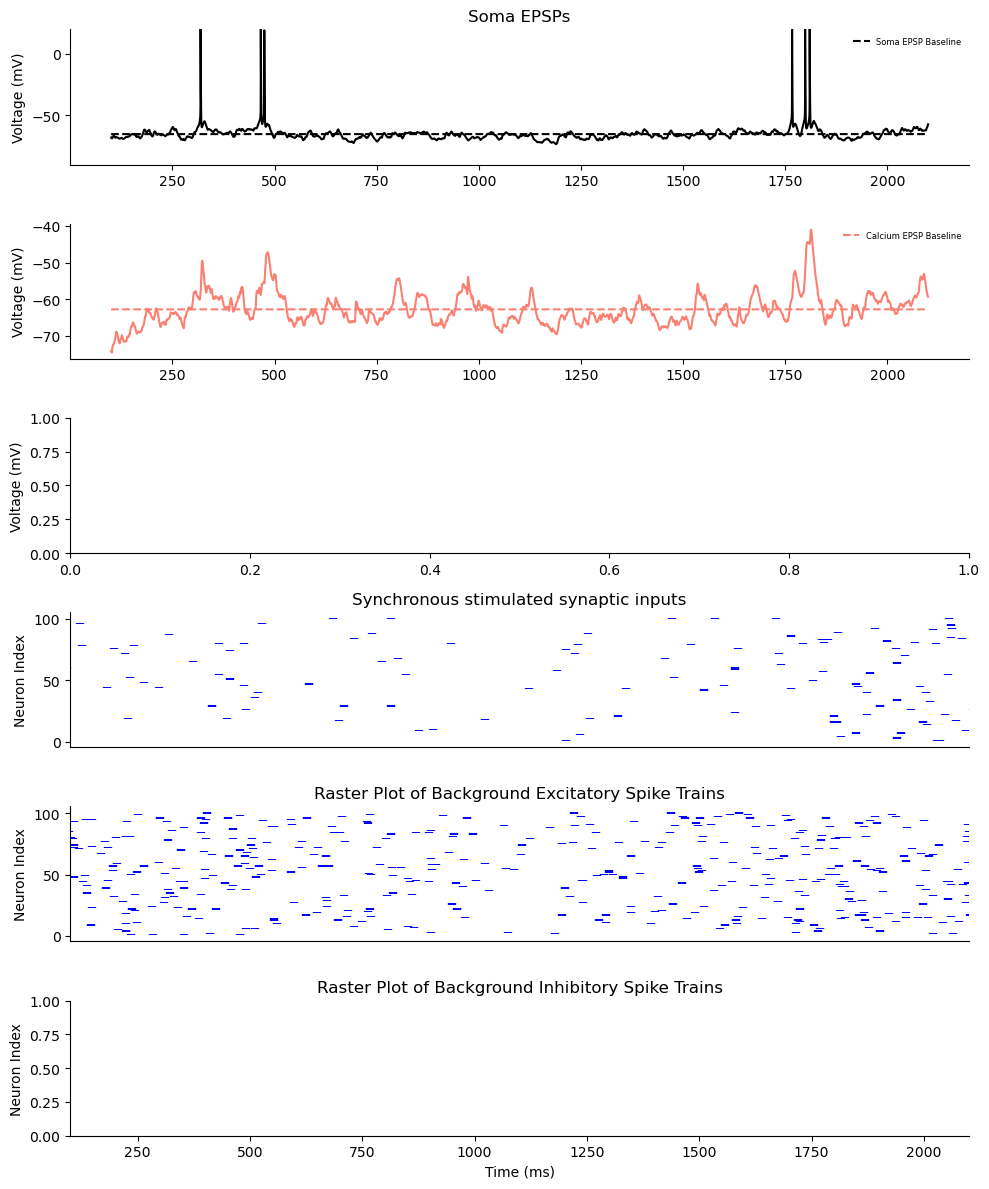

In [7]:
syn_num, trial_idx, epoch_idx = 0, 0, 5
for epoch_idx in [1]:
    visualization(f'basal_range0_clus_invivo_NATURAL_exc1.3/1/{epoch_idx}', 
                  syn_num=syn_num, trial_idx=trial_idx, t_start=100, t_end=2100)